In [36]:
from sympy import *
from matplotlib import pyplot as plt
import pandas as pd

In [67]:
def seq(t1=Symbol('t_1'),
           t2=Symbol('t_2'),
           l=Symbol('l'),
           q=Symbol('q'),
           m1=Symbol('m_1'),
           m2=Symbol('m_2'),
           b1=Symbol('b_1'),
           b2=Symbol('b_2'), v=False, inter=True,corner=True):
    
    #profits
    pi1 = .5*( (t2-t1)/3 +q)*(1 + (t2-t1)/(3*q) )
    pi2 = .5*( (t1-t2)/3 +q)*(1 + (t1-t2)/(3*q) )

    #use SPE/backward induction to solve game
    v2 = (pi2 - pi2.subs(t2,l) )**(b2) * (m1*t1 +m2*t2)**(1-b2)
    v2_foc = diff(v2,t2)
    
    solutions = []
    
    #initialize no bargain, list price both
    if corner:
        solutions.append( (l,q,m1,m2,b1,b2,l,l,.5*q,.5*q) )
    
    #solve for t1 as a function of t2
    if inter:
        h1_list = solve(v2_foc,t2,force=True)
        if v: print 'h1_list: %s\n'%h1_list
    
        for h1 in h1_list:
        
            #susbitute h1 for t2, then substitute l into the second term for t1
            h1 = simplify(h1)
            pi1_h = pi1.subs(t2,h1)
            pi1_l = pi1_h.subs(t1,l)
            v1 = (pi1.subs(t2,h1) - pi1_l ) * (m1*t1 + m2*h1)
            v1_foc = diff(v1,t1)
            if v: print 'solving t1_foc ...'
        
            t1_sol = solve(v1_foc,t1,rational=False,force=True)
            t1_sol = [t1_cand for t1_cand in t1_sol if t1_cand.is_real]
       
            if v: print 't1_sol: %s\n'%t1_sol
            for t1_param in t1_sol: 
                t2_param = h1.subs(t1,t1_param) 
                pi1_param = pi1.subs({t1:t1_param, t2:t2_param})
                pi2_param = pi2.subs({t1:t1_param, t2:t2_param})
                solutions.append((l,q,m1,m2,b1,b2,t1_param,t2_param,pi1_param,pi2_param))
        
        return solutions

test_seq1 = seq(l = 5, q = 1, m1 = .2, m2 = .5, b1 = .5, b2 = .5, v=False)
print test_seq1
test_seq2 = seq(l = 10, q = 1, m1 = .2, m2 = .5, b1 = .5, b2 = .5, v=False)
print test_seq2

[(5, 1, 0.2, 0.5, 0.5, 0.5, 5, 5, 0.5, 0.5), (5, 1, 0.2, 0.5, 0.5, 0.5, -17.3251658604378, -20.4569590023983, 0.000964968459323691, 2.08882706309967), (5, 1, 0.2, 0.5, 0.5, 0.5, -5.89861737276086, -6.03141467996201, 0.456713960088500, 0.545245498222597), (5, 1, 0.2, 0.5, 0.5, 0.5, 0.982779904770486, 0.951725824054472, 0.489702215090724, 0.510404935568067), (5, 1, 0.2, 0.5, 0.5, 0.5, 4.08829018210590, 1.03250900499431, 0.000172863317775248, 2.03736031472550), (5, 1, 0.2, 0.5, 0.5, 0.5, -7.40550001749375, 4.01020326285304, 11.5451389481667, 3.93467009460220), (5, 1, 0.2, 0.5, 0.5, 0.5, 2.65194077812066, 5.68337825916700, 2.02101322709837, 5.49064008077185e-5)]
[(10, 1, 0.2, 0.5, 0.5, 0.5, 10, 10, 0.5, 0.5), (10, 1, 0.2, 0.5, 0.5, 0.5, -17.2458209579898, -22.8703039557566, 0.382661722531488, 4.13231705437599), (10, 1, 0.2, 0.5, 0.5, 0.5, 6.41708027323220, 1.41365327195421, 0.222984430524984, 3.55860243137698), (10, 1, 0.2, 0.5, 0.5, 0.5, -14.5228042566003, 7.95806827461992, 36.07082583068

In [60]:
def inter_simult(t1,t2,v1_foc,v2_foc,
                 l,q,m1,m2,b1,b2,pi1,pi2,v):
    solutions = [(l,q,m1,m2,b1,b2,l,l,.5*q,.5*q)]
    #solve for t2 as a function of t1
    if v: print 'solving v2_foc... \n'
    t2_sol = solve(v2_foc,t2)
    if v: print 't2_sol: %s \n'%t2_sol 
    for t2_param in t2_sol:
        #substitute back into foc
        v1_foc1 = v1_foc.subs(t2,t2_param)  
        if v: print 'solving v1_foc... \n'
        t1_param = solve(v1_foc1,t1)        
        t1_param = [t1_cand for t1_cand in t1_param if t1_cand.is_real]
        if v: print 't2_param: %s, t1_param: %s \n'%(t2_param, t1_param)  
        #sovle for t2
        t2_param = [t2_param.subs(t1, t1_cand) for t1_cand in t1_param]
        for i in range(len(t1_param)): 
            pi1_param = pi1.subs({t1:t1_param[i], t2:t2_param[i]})
            pi2_param = pi2.subs({t1:t1_param[i], t2:t2_param[i]})
            solutions.append((l,q,m1,m2,b1,b2,t1_param[i],t2_param[i],pi1_param,pi2_param))   
    return solutions


def corner_simult(t1,t2,v1_foc,v2_foc,
                  l,q,m1,m2,b1,b2,pi1,pi2,v):
    solutions = []
    
    #case 1: t2 = l, t1 interior (good one)
    v1_foc1 = v1_foc.subs(t2,l) 
    if v: print 'solving foc 1 in corner case... \n'
    t1_sol = solve(v1_foc1,t1)        
    t1_sol = [t_cand for t_cand in t1_sol if t_cand.is_real]
    if v: print 't1_sol in corner: %s \n'%(t1_sol)  
    #add solutions to list
    for t1_param in t1_sol:
        pi1_param1 = S(.5)*( (l-t1_param)/S(3) +q) *(1 + (l-t1_param)/(S(3)*q) )
        pi2_param1 = S(.5)*( (t1_param-l)/S(3) +q) *(1 + (t1_param-l)/(S(3)*q) )
        solutions.append((l,q,m1,m2,b1,b2,t1_param,l,pi1_param1,pi2_param1))

    #case 2: t1 = l, t2 interior (broken one)
    v2_foc2 = v2_foc.subs(t1,l) 
    if v: print 'solving foc 2 in corner case... \n'
    t2_sol = solve(v2_foc2,t2)        
    t2_sol = [t_cand for t_cand in t2_sol if t_cand.is_real]
    if v: print 't2_sol in corner: %s \n'%(t2_sol)  
    #add solutions to list
    for t2_param in t2_sol:
        pi1_param2 = S(.5)*( (t2_param-l)/S(3) +q) *(1 + (t2_param-l)/(S(3)*q) )
        pi2_param2 = S(.5)*( (l-t2_param)/S(3) +q) *(1 + (l-t2_param)/(S(3)*q) )
        solutions.append((l,q,m1,m2,b1,b2,l,t2_param, pi1_param2,pi2_param2))
    
    return solutions
    

def simult(t1=Symbol('t_1'),
           t2=Symbol('t_2'),
           l=Symbol('l'),
           q=Symbol('q'),
           m1=Symbol('m_1'),
           m2=Symbol('m_2'),
           b1=Symbol('b_1'),
           b2=Symbol('b_2'), v=False, inter=True,corner=True):
    
    #profits
    pi1 = S(.5)*( (t2-t1)/S(3) +q)*(S(1) + (t2-t1)/(S(3)*q) )
    pi2 = S(.5)*( (t1-t2)/S(3) +q)*(S(1) + (t1-t2)/(S(3)*q) )
    #nash bargaining objectives
    v1 = (pi1 - pi1.subs(t1,l) )**(b1) * (m1*t1 +m2*t2)**(S(1)-b1)
    v2 = (pi2 - pi2.subs(t2,l) )**(b2) * (m1*t1 +m2*t2)**(S(1)-b2)
    #simultaneous bargaining
    v1_foc = diff(v1,t1)
    v2_foc = diff(v2,t2)
    #initialize no bargain, list price both
    solutions = []
    #other less important cases:
    if corner:
        corner_solutions = corner_simult(t1,t2, v1_foc, v2_foc,
                                     l,q,m1,m2,b1,b2,pi1,pi2,v)
        for sol in  corner_solutions:
            solutions.append(sol)
    #interior cases:
    if inter:
        int_solutions = inter_simult(t1,t2,v1_foc,v2_foc,
                                 l,q,m1,m2,b1,b2,pi1,pi2,v)
        for sol in int_solutions:
            solutions.append(sol)
    return solutions

#test_sim1 = simult(l = 1, q = 1, m1 = .5, m2 = .5, b1 = .5, b2 = .5, v=False, inter=True, corner=True)
#print test_sim1

test_sim2 = simult(l = 5.6, q =1 , m1 = .5, m2 = .5, b1 = .5, b2 = .5, v=False, inter=True, corner=True)
#print test_sim2
print find_eq(test_sim2)

test_sim3 = simult(l = 5.4, q =1 , m1 = .5, m2 = .5, b1 = .5, b2 = .5, v=False, inter=True, corner=True)
#print test_sim3
print find_eq(test_sim3)

test_sim4 = simult(l = 1, q =1 , m1 = 0.0, m2 = .5, b1 = .5, b2 = .5, v=False, inter=True, corner=True)
#print test_sim3
print find_eq(test_sim4)

[(5.6, 1, 0.5, 0.5, 0.5, 0.5, -1.17361551238288, 5.6, 5.30686445466063, 0.791120779738706), (5.6, 1, 0.5, 0.5, 0.5, 0.5, 5.6, -1.17361551238288, 0.791120779738706, 5.30686445466063), (5.6, 1, 0.5, 0.5, 0.5, 0.5, 0.314835124201342, 0.314835124201342, 0.500000000000000, 0.500000000000000)]
[(5.4, 1, 0.5, 0.5, 0.5, 0.5, -1.11528229097780, 5.4, 5.03003317094421, 0.686511643625675), (5.4, 1, 0.5, 0.5, 0.5, 0.5, 5.4, -1.11528229097780, 0.686511643625675, 5.03003317094421), (5.4, 1, 0.5, 0.5, 0.5, 0.5, 0.424922359499621, 0.424922359499621, 0.500000000000000, 0.500000000000000)]
[(1, 1, 0.0, 0.5, 0.5, 0.5, 1, 0.480853825232666, 0.341924205676197, 0.688021655521087)]


In [50]:
#still in progress, need to compare nash bargaining objectives to each other. 
#make sure to check that they are not equal. maximum will not be strictly less than its self?

def find_eq(candidates,v=False):
    solutions = []
    if len(candidates) == 1:
        return candidates
    for sol_0 in candidates:
        l_0,q_0,m1_0,m2_0,b1_0,b2_0,t1_0,t2_0,pi1_0,pi2_0 = sol_0
        
        pi1_l0 = S(.5)*( (t2_0-l_0)/S(3) +q_0)*(1 + (t2_0-l_0)/(S(3)*q_0) )
        pi2_l0 = S(.5)*( (t1_0-l_0)/S(3) +q_0)*(1 + (t1_0-l_0)/(S(3)*q_0) )

        v1_0 = (pi1_0 - pi1_l0)**(b1_0) * (m1_0*t1_0 +m2_0*t2_0)**(1-b1_0)
        v2_0 = (pi2_0 - pi2_l0)**(b2_0) * (m1_0*t1_0 +m2_0*t2_0)**(1-b2_0)
        if v: print 'pi1_0: %s, pi2_0: %s, v1_0: %s, v2_0: %s, t1_0: %s, t2_0: %s, \n'%(pi1_0,pi2_0,v1_0,v2_0,t1_0,t2_0)
        nash = True
        for sol in candidates:
            l,q,m1,m2,b1,b2,t1,t2,pi1,pi2 = sol  
            pi1_l = S(.5)*( (t2-l)/S(3) +q) *(1 + (t2-l)/(S(3)*q) )
            pi2_l = S(.5)*( (t1-l)/S(3) +q) *(1 + (t1-l)/(S(3)*q) )
                
            #nash bargaining objectives - non candidate
            v1 = (pi1 - pi1_l )**(b1) * (m1*t1 +m2*t2)**(1-b1)
            v2 = (pi2 - pi2_l )**(b2) * (m1*t1 +m2*t2)**(1-b2)
            v0_real =  v1_0.is_real and v2_0.is_real
            v_real =  v2.is_real and v1.is_real
            if v: print 'pi1: %s, pi2: %s, v1: %s, v2: %s , t1: %s, t2:%s \n'%(pi1, pi2, v1,v2,t1,t2)
            nash = nash and v0_real and (not v_real or v1 < v1_0 or v2 <v2_0 or (v1 == v1_0 and v2 == v2_0))
        if nash: 
            solutions.append(sol_0)
    return solutions

print find_eq(test_sim1,v=False)
print find_eq(test_sim2,v=False)

[(1, 1, 0.5, 0.5, 0.5, 0.5, -0.0703675169759929, 1, 0.920438429069628, 0.206860084418966), (1, 1, 0.5, 0.5, 0.5, 0.5, 1, -0.0703675169759929, 0.206860084418966, 0.920438429069628), (1, 1, 0.5, 0.5, 0.5, 0.5, 0.306623862918075, 0.306623862918075, 0.500000000000000, 0.500000000000000)]
[(5.6, 1, 0.5, 0.5, 0.5, 0.5, -1.17361551238288, 5.6, 5.30686445466063, 0.791120779738706), (5.6, 1, 0.5, 0.5, 0.5, 0.5, 5.6, -1.17361551238288, 0.791120779738706, 5.30686445466063), (5.6, 1, 0.5, 0.5, 0.5, 0.5, 0.314835124201342, 0.314835124201342, 0.500000000000000, 0.500000000000000)]


In [61]:
def l_plotter(game, ranger, scaler, args, v=False):
    q0, m10, m20, b10, b20 = args
    result = []
    for l in ranger: 
        l = l/scaler
        solutions = game(l = l ,q = q0, m1 = m10, m2 = m20, b1 = b10, b2 = b20)
        solutions = find_eq(solutions)
        if v: print 'solutions: %s \n'%solutions
        for sol in solutions:
            result.append(sol) 
    result = pd.DataFrame(result, columns=['l','lambda','mu_1','mu_2','beta_1','beta_2','theta_1','theta_2','pi_1','pi_2']) 
    return result


def q_plotter(game, ranger, scaler, args,v=False): 
    l0, m10, m20, b10, b20  = args 
    result = [] 
    for q in ranger: 
        q = q/scaler 
        solutions = game(l = l0 ,q = q, m1 = m10, m2 = m20, b1 = b10, b2 = b20)
        solutions = find_eq(solutions)
        if v: print 'solutions: %s \n'%solutions
        for sol in solutions:
            result.append(sol) 
    result = pd.DataFrame(result, columns=['l','lambda','mu_1','mu_2','beta_1','beta_2','theta_1','theta_2','pi_1','pi_2'])
    return result


def m_plotter(game, ranger, scaler, args,v=False): 
    q0, l0, m20, b10, b20  = args 
    result = [] 
    for m in ranger:
        m = m/scaler 
        if v: print 'l: %s, q: %s, m1: %s, m2: %s, b1: %s, b2: %s \n'%(l0 ,q0, m, m20,  b10, b20)
        solutions = game(l = l0 ,q = q0, m1 = m, m2 = m20, b1 = b10, b2 = b20)
        if v: print '(unfiltered) solutions: %s \n'%solutions
        solutions = find_eq(solutions)
        if v: print 'solutions: %s \n'%solutions
        for sol in solutions:
            result.append(sol) 
    result = pd.DataFrame(result, columns=['l','lambda','mu_1','mu_2','beta_1','beta_2','theta_1','theta_2','pi_1','pi_2'])
    return result

In [41]:
def quick_plot(frame,ptype,fname):
    #plot pi
    fig = plt.figure()
    fig.suptitle('pi  vs %s'%ptype)
    plt.ylabel('pi(%s)'%ptype)
    plt.xlabel(ptype)
    plt.plot(frame[ptype] ,frame['pi_1'], 'ro')
    plt.plot(frame[ptype] ,frame['pi_2'], 'bo')
    fig.savefig('plots/%s_pi_%s'%(fname,ptype))
    
    #plot theta
    fig = plt.figure()
    fig.suptitle('theta  vs %s'%ptype)
    plt.ylabel('theta(%s)'%ptype)
    plt.xlabel(ptype)
    plt.plot(frame[ptype] ,frame['theta_1'], 'ro')
    plt.plot(frame[ptype] ,frame['theta_2'], 'bo')
    fig.savefig('plots/%s_theta_%s'%(fname,ptype))

In [42]:
arg0 =  (1, .5,.5,.5,.5)
simult1_l =  l_plotter(simult,range(10,70,5),10.0, arg0, v=False)

print simult1_l

      l  lambda  mu_1  mu_2  beta_1  beta_2              theta_1  \
0   1.0       1   0.5   0.5     0.5     0.5  -0.0703675169759929   
1   1.0       1   0.5   0.5     0.5     0.5                    1   
2   1.0       1   0.5   0.5     0.5     0.5    0.306623862918075   
3   1.5       1   0.5   0.5     0.5     0.5   -0.145751311064591   
4   1.5       1   0.5   0.5     0.5     0.5                  1.5   
5   1.5       1   0.5   0.5     0.5     0.5    0.437253933193776   
6   2.0       1   0.5   0.5     0.5     0.5   -0.239265962360449   
7   2.0       1   0.5   0.5     0.5     0.5                    2   
8   2.0       1   0.5   0.5     0.5     0.5    0.549834435270750   
9   2.5       1   0.5   0.5     0.5     0.5   -0.346464004723152   
10  2.5       1   0.5   0.5     0.5     0.5                  2.5   
11  2.5       1   0.5   0.5     0.5     0.5    0.641428428542850   
12  3.0       1   0.5   0.5     0.5     0.5   -0.464101615137755   
13  3.0       1   0.5   0.5     0.5     0.5     

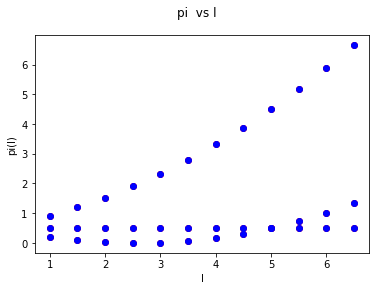

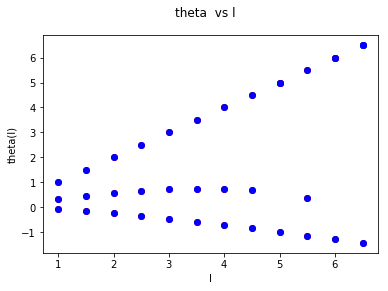

In [43]:
simult1_l.to_csv('sheets/simult1_l.csv', sep=',')
quick_plot(simult1_l,'l','simult1')

In [44]:
arg0 =  (1, .5,.5,.5,.5)
simult1_q =  q_plotter(simult,range(10,70,5),10.0, arg0)

print simult1_q

    l  lambda  mu_1  mu_2  beta_1  beta_2              theta_1  \
0   1     1.0   0.5   0.5     0.5     0.5  -0.0703675169759929   
1   1     1.0   0.5   0.5     0.5     0.5                    1   
2   1     1.0   0.5   0.5     0.5     0.5    0.306623862918075   
3   1     1.5   0.5   0.5     0.5     0.5  -0.0496305216974065   
4   1     1.5   0.5   0.5     0.5     0.5                    1   
5   1     1.5   0.5   0.5     0.5     0.5    0.316005617976297   
6   1     2.0   0.5   0.5     0.5     0.5  -0.0382923495346671   
7   1     2.0   0.5   0.5     0.5     0.5                    1   
8   1     2.0   0.5   0.5     0.5     0.5    0.320508075688773   
9   1     2.5   0.5   0.5     0.5     0.5  -0.0311589798103604   
10  1     2.5   0.5   0.5     0.5     0.5                    1   
11  1     2.5   0.5   0.5     0.5     0.5    0.323152842795195   
12  1     3.0   0.5   0.5     0.5     0.5  -0.0262613427796377   
13  1     3.0   0.5   0.5     0.5     0.5                    1   
14  1     

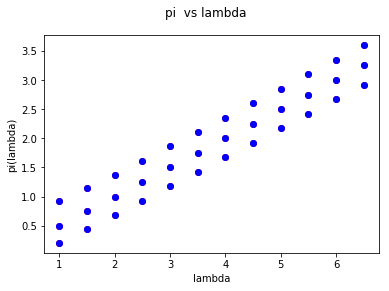

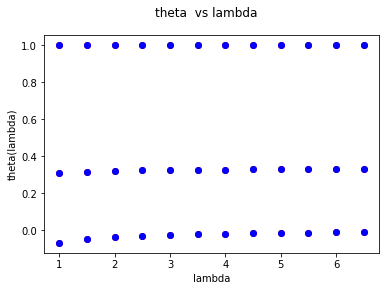

In [45]:
simult1_q.to_csv('sheets/simult1_lambda.csv', sep=',')
quick_plot(simult1_q,'lambda','simult1')

In [70]:
arg0 =  (1,1,.5,.5,.5)

simult1_m =  m_plotter(simult,range(0,10,1),10.0, arg0, v=False)


print simult1_m

[(1, 1, 0.0, 0.5, 0.5, 0.5, 4.00000000000000, 1, 0, 2.00000000000000), (1, 1, 0.0, 0.5, 0.5, 0.5, 1, 0.480853825232666, 0.341924205676197, 0.688021655521087), (1, 1, 0.0, 0.5, 0.5, 0.5, 1, 4.85247950810067, 2.60869307827442, 0.0403734062073086), (1, 1, 0.0, 0.5, 0.5, 0.5, 1, 1, 0.5, 0.5), (1, 1, 0.0, 0.5, 0.5, 0.5, -19.4891252930761, -22.4891252930761, 0, 2.00000000000000), (1, 1, 0.0, 0.5, 0.5, 0.5, -2.50000000000000, 1.66533453693773e-16, 1.68055555555556, 0.0138888888888889), (1, 1, 0.0, 0.5, 0.5, 0.5, 3.48912529307606, 0.489125293076057, 3.46667389989702e-33, 2.00000000000000), (1, 1, 0.0, 0.5, 0.5, 0.5, -19.4891252930761, 0.503624902307982, 29.3703645304074, 16.0418644001513), (1, 1, 0.0, 0.5, 0.5, 0.5, -2.50000000000000, 0.666666666666667, 2.11265432098765, 0.00154320987654321), (1, 1, 0.0, 0.5, 0.5, 0.5, 3.48912529307606, 8.16304176435868, 3.27161077823460, 0.155666464046182)] 

l: 1, q: 1, m1: 0.0, m2: 0.5, b1: 0.5, b2: 0.5 

(unfiltered) solutions: [(1, 1, 0.0, 0.5, 0.5, 0.5, 

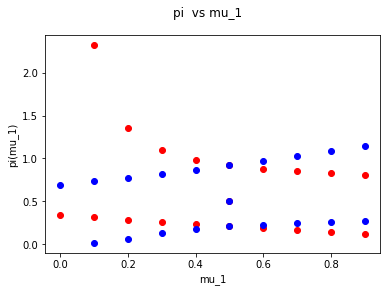

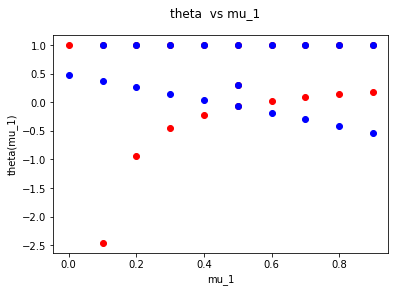

In [71]:
simult1_m.to_csv('sheets/simult1_mu.csv', sep=',')
quick_plot(simult1_m,'mu_1','simult1')

In [44]:
arg0 =  (1, .5,.5,.5,.5)
seq1_l =  l_plotter(seq,range(10,70,5),10.0, arg0)

print seq1_l

     l  lambda  mu_1  mu_2  beta_1  beta_2               theta_1  \
0  1.0       1   0.5   0.5     0.5     0.5    -0.147145085939096   
1  1.5       1   0.5   0.5     0.5     0.5    -0.303681583792988   
2  2.0       1   0.5   0.5     0.5     0.5    -0.359215633855141   
3  2.5       1   0.5   0.5     0.5     0.5    -0.208499119565499   
4  3.0       1   0.5   0.5     0.5     0.5  -0.00767298650952219   
5  3.5       1   0.5   0.5     0.5     0.5     0.164467717556068   
6  4.0       1   0.5   0.5     0.5     0.5     0.274604201843384   
7  4.5       1   0.5   0.5     0.5     0.5     0.286299647846891   

             theta_2               pi_1               pi_2  
0  0.551742350534693  0.760098237094646  0.294173279445454  
1  0.843719132692198  0.955607372394546  0.190673561404422  
2   1.03452905142967   1.07249957552603  0.143336452002822  
3   1.05320543701854   1.00900698486718  0.167870613811149  
4   1.00254779931311  0.893437263946880  0.219956740065129  
5  0.928394744341327 

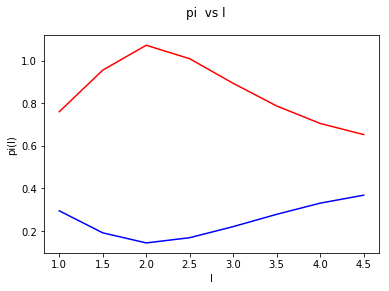

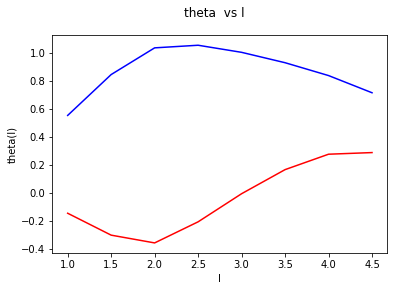

In [45]:
seq1_l.to_csv('sheets/seq1_l.csv', sep=',')
quick_plot(seq1_l,'l','seq1')

In [46]:
arg0 =  (1, .5,.5,.5,.5)
seq1_q =  q_plotter(seq,range(10,50,5),10.0, arg0)

print seq1_q

   l  lambda  mu_1  mu_2  beta_1  beta_2              theta_1  \
0  1     1.0   0.5   0.5     0.5     0.5   -0.147145085939096   
1  1     1.5   0.5   0.5     0.5     0.5  -0.0982007977889851   
2  1     2.0   0.5   0.5     0.5     0.5  -0.0730407292674440   
3  1     2.5   0.5   0.5     0.5     0.5  -0.0580104823845639   
4  1     3.0   0.5   0.5     0.5     0.5  -0.0480677795584796   
5  1     3.5   0.5   0.5     0.5     0.5  -0.0410175465106055   
6  1     4.0   0.5   0.5     0.5     0.5  -0.0357629749259386   
7  1     4.5   0.5   0.5     0.5     0.5  -0.0316976969554445   

             theta_2               pi_1               pi_2  
0  0.551742350534693  0.760098237094646  0.294173279445454  
1  0.535128048882948  0.975965372150896  0.553746141036274  
2  0.526125823816034   1.20969442209266  0.810250053370339  
3  0.520707601908623   1.45034857523302   1.06453651903756  
4  0.517122937508138   1.69431247136773   1.31751865998998  
5  0.514585146804239   1.94010080813382   1.5696

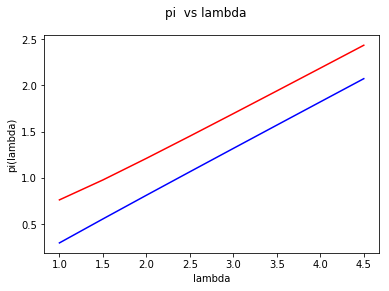

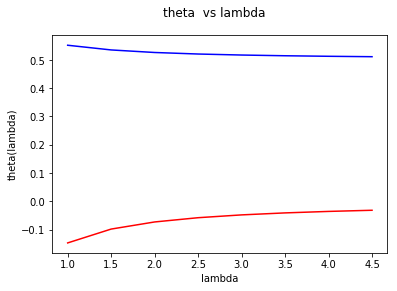

In [47]:
seq1_q.to_csv('sheets/seq1_lambda.csv', sep=',')
quick_plot(seq1_q,'lambda','seq1')

In [48]:
arg0 =  (1,1,.5,.5,.5)
seq1_m =  m_plotter(seq,range(0,10,1),10.0, arg0)

print seq1_m

   l  lambda  mu_1  mu_2  beta_1  beta_2              theta_1  \
0  1       1   0.0   0.5     0.5     0.5    -1.75600605693336   
1  1       1   0.1   0.5     0.5     0.5    -1.58958798717453   
2  1       1   0.2   0.5     0.5     0.5   -0.983282193446326   
3  1       1   0.3   0.5     0.5     0.5   -0.523221520527885   
4  1       1   0.4   0.5     0.5     0.5   -0.286797175242155   
5  1       1   0.5   0.5     0.5     0.5   -0.147145085939096   
6  1       1   0.6   0.5     0.5     0.5  -0.0563052106391731   
7  1       1   0.7   0.5     0.5     0.5  0.00657996685665731   
8  1       1   0.8   0.5     0.5     0.5   0.0519405652404193   
9  1       1   0.9   0.5     0.5     0.5   0.0855520048409346   

             theta_2               pi_1                pi_2  
0  0.391389666972949   1.47198237436050  0.0403852250896252  
1  0.611779703671495   1.50301254752094  0.0354340869569231  
2  0.677210259201363   1.20667721673256  0.0996822483007668  
3  0.639261554462250  0.962570297198

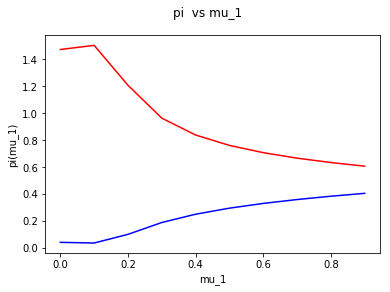

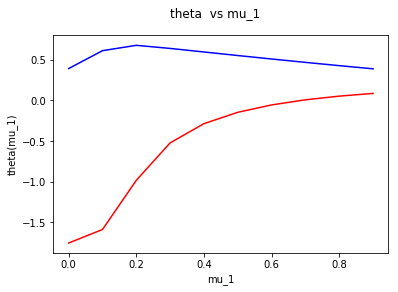

In [49]:
seq1_m.to_csv('sheets/seq1_mu.csv', sep=',')
quick_plot(seq1_m,'mu_1','seq1')